In [2]:
import pandas as pd

df = pd.read_csv('qtdbsel102.txt', header=None, delimiter='\t')
df.head()

,0,1,2
0,200.000,4.770,2.100
1,200.004,4.820,2.135
2,200.008,4.805,2.190
3,200.012,4.750,2.285
4,200.016,4.710,2.440


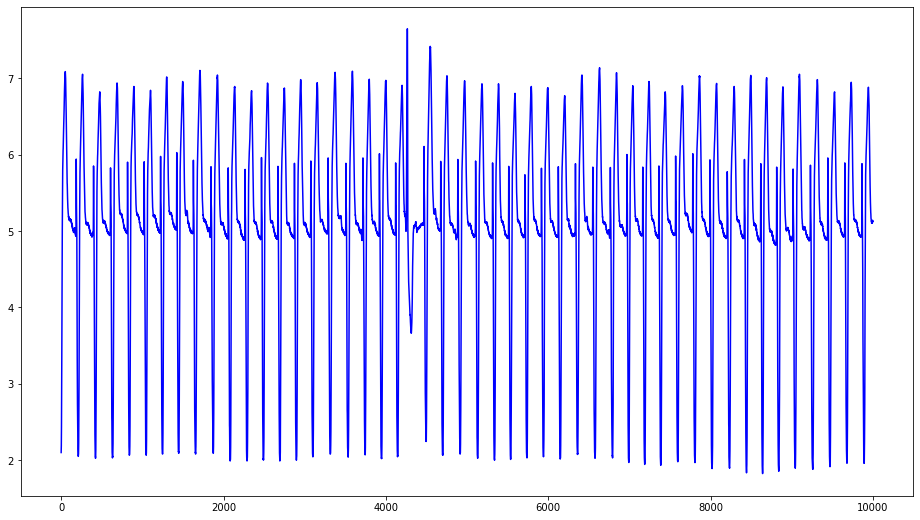

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

ecg_dataset = df.iloc[:,2].values
ecg_dataset = ecg_dataset[:10000]
ecg_dataset = ecg_dataset.reshape(len(ecg_dataset), -1)

plt.figure(figsize=(16, 9))
plt.plot(ecg_dataset, color='b')
plt.show()

In [4]:
import numpy as np

# 平均値を0にする
ecg_dataset_mean = ecg_dataset.mean()
ecg_dataset = (ecg_dataset - ecg_dataset_mean)

# データセットの最大値で割り、-1～1の範囲に収まるように正規化する
ecg_dataset_max = np.abs(ecg_dataset).max()
ecg_dataset = ecg_dataset / ecg_dataset_max

In [5]:
train_data = ecg_dataset[5000:10000]
test_data = ecg_dataset[:5000]

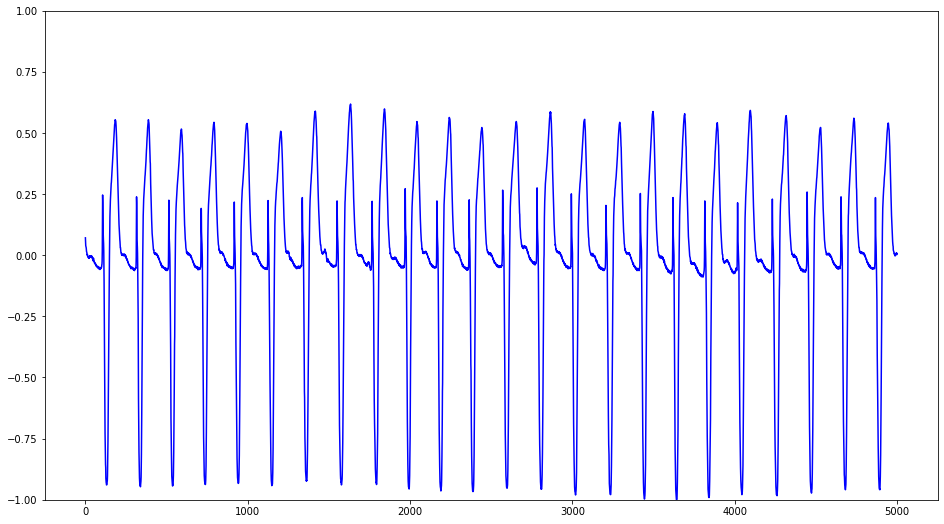

In [6]:
# 学習データプロット
plt.figure(figsize=(16, 9))
plt.ylim(-1, 1)
plt.plot(train_data, color='b')
plt.show()

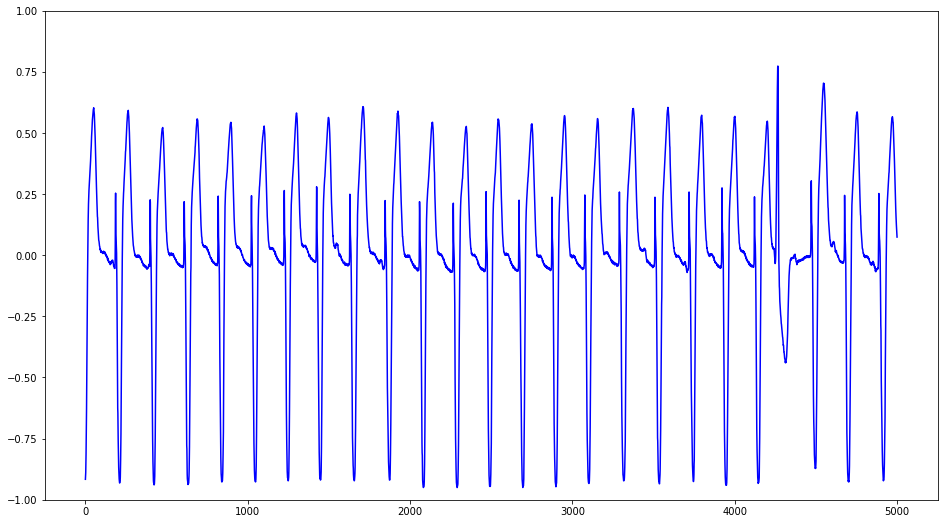

In [7]:
# テストデータプロット
plt.figure(figsize=(16, 9))
plt.ylim(-1, 1)
plt.plot(test_data, color='b')
plt.show()

In [8]:
TIME_STEPS = 128

def create_dataset_list(array, time_steps=TIME_STEPS):
    dataset_list = []

    for i in range(len(array) - time_steps + 1):
        dataset_list.append(array[i : (i + time_steps)])

    return np.stack(dataset_list)

In [9]:
x_train = create_dataset_list(train_data)

print(train_data.shape)
print(x_train.shape)

(5000, 1)
(4873, 128, 1)


In [10]:
x_test = create_dataset_list(test_data)

print(test_data.shape)
print(x_test.shape)

(5000, 1)
(4873, 128, 1)


In [11]:
import os
import random
import tensorflow as tf

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [12]:
model = tf.keras.Sequential(
    [
        # 入力層
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS, 1)),
     
        # エンコード層
        tf.keras.layers.Conv1D(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
       
        # デコード層
        tf.keras.layers.Conv1DTranspose(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1DTranspose(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
    
        # 出力層
        tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)

2021-11-13 00:32:05.609369: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 64)            512       
                                                                 
 dropout (Dropout)           (None, 64, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 32)            14368     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 64, 64)           14400     
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 128, 64)          28736     
 ranspose)                                              

In [14]:
history = model.fit(
    x=x_train,  # 学習データ
    y=x_train,  # 教師データ(オートエンコーダの学習のため学習データをそのまま入れる)
    validation_split=0.1,  # 検証データ比率(学習データの1割を検証データとして使用する)
    epochs=50,  # エポック数
    batch_size=128,  # バッチサイズ
    callbacks=[
        # コールバック指定
        # 5回検証Lossの改善が無かったら学習を打ち切るよう設定
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
35/35 [==============================] - 2s 43ms/step - loss: 0.0348 - val_loss: 0.0043
Epoch 2/50
35/35 [==============================] - 1s 37ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 3/50
35/35 [==============================] - 1s 40ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 4/50
35/35 [==============================] - 1s 40ms/step - loss: 0.0021 - val_loss: 8.7375e-04
Epoch 5/50
35/35 [==============================] - 2s 43ms/step - loss: 0.0015 - val_loss: 6.4822e-04
Epoch 6/50
35/35 [==============================] - 1s 40ms/step - loss: 0.0012 - val_loss: 4.5074e-04
Epoch 7/50
35/35 [==============================] - 1s 37ms/step - loss: 9.5630e-04 - val_loss: 3.3949e-04
Epoch 8/50
35/35 [==============================] - 1s 42ms/step - loss: 8.4134e-04 - val_loss: 5.7747e-04
Epoch 9/50
35/35 [==============================] - 1s 41ms/step - loss: 7.6802e-04 - val_loss: 5.6147e-04
Epoch 10/50
35/35 [==============================] - 1s 42ms/step - loss:

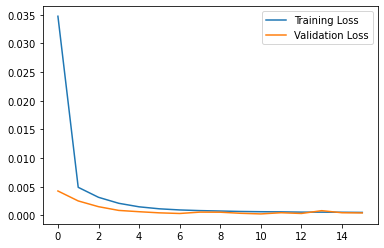

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()